#### Import the needed libraries

In [204]:
import os
import re
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import layers
from tensorflow import data as tf_data
from keras.applications import EfficientNetB0

#### Data Cleaning

As duplicates can be found in the dataset; with filenames ending with (1), (2), (3), etc., we clean the data by removing said duplicates. We also remove any corrupted files.

In [205]:
data_dir = '../../dataset_26'

# Regular expression pattern to match filenames ending with (1), (2), (3), etc.
pattern = re.compile(r'\(\d+\)\.\w+$')

num_skipped = 0 # Images deleted

# Iterate over each folder in the dataset
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            try:
                fobj = open(image_path, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(image_path)
            
            # Check if the filename matches the pattern
            if pattern.search(image):
                # Remove the duplicate image
                os.remove(image_path)
                
print(f"Deleted {num_skipped} images.")

Deleted 0 images.


#### Dataset Generation

In [206]:
image_size = (224, 224)
batch_size = 64

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 454 files belonging to 4 classes.
Using 364 files for training.
Using 90 files for validation.
['glioma', 'meningioma', 'notumor', 'pituitary']


In [207]:
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))

#### Data Visualization

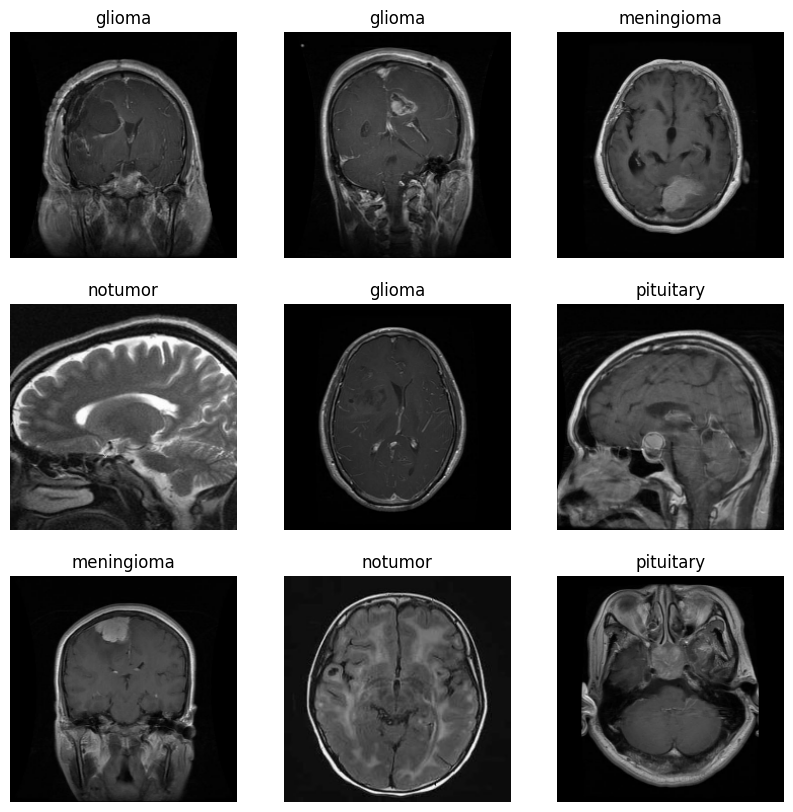

In [208]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Data Augmentation

In [209]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

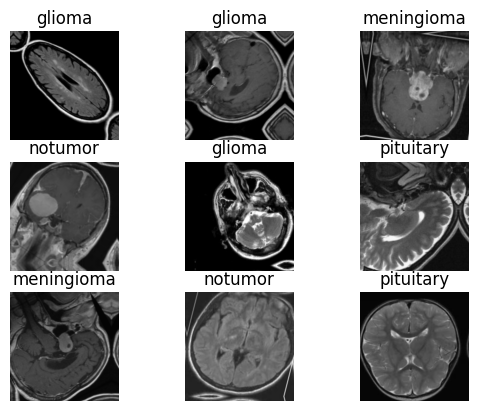

In [210]:
for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images = img_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Prepare Inputs

In [211]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, num_classes)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label


train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)

#### Training the Model

In [212]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=num_classes,
    input_shape=(224, 224, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_58        │ (None, 224, 224,  │          0 │ input_layer_46[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_37    │ (None, 224, 224,  │          7 │ rescaling_58[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_37… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 13s/step - accuracy: 0.2932 - loss: 3.7855 - val_accuracy: 0.2111 - val_loss: 1.4117
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 13s/step - accuracy: 0.3706 - loss: 2.4859 - val_accuracy: 0.2111 - val_loss: 1.4211
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 14s/step - accuracy: 0.3041 - loss: 2.8636 - val_accuracy: 0.3111 - val_loss: 1.4703
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.4137 - loss: 2.4295 - val_accuracy: 0.2111 - val_loss: 1.4595
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 14s/step - accuracy: 0.4004 - loss: 2.0695 - val_accuracy: 0.2111 - val_loss: 1.4375
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 13s/step - accuracy: 0.4406 - loss: 1.5585 - val_accuracy: 0.3111 - val_loss: 1.3980
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 13s/step - accuracy: 0.4520 - loss: 1.7989 - val_accuracy: 0.2222 - val_loss: 1.4815
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 13s/step - accuracy: 0.5083 - loss: 1.5981 - val_accuracy: 0.3111 - val_loss: 1.5477

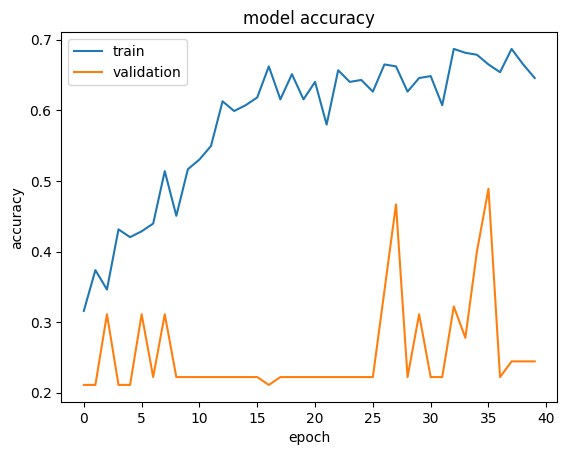

In [214]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)